In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'corel-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F462387%2F869652%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T092417Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7343e90d51d1a18b8231a9e0628c46575acb4f86f7ef0919cf68c237549e24213c4e14c97773d4f0f8ec2ad9bcbe27ce337ee4ff17f377e783274e3ee0f7d898cc3418e7f2d733a92e4ca5f56c9e671beb99c2ba6942f0f4de7860bc016b19f938ad4c32b59ef35cc3b7be10b8173503717509993555ac2cbfa16c5b77616a453f2a338b34d4b290d460515ac9e3dccb8e8f69c4dd17bf31ce573bb1d835a929b61ed39aa2ca69501f500866107f108c6f7ac0c0b7d169841b76a86a1be27e564290ca891fbc100b0f502a3cf55bc1ca97d10ff68d046bda91999f892b740b7ef4cc2cf433e5c0b21efe5a24fa7f6ca64c07d9733fae5b68af366c3317105cc3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29867737 bytes downloaded
Downloaded and uncompressed: corel-images
Data source import complete.


In [ ]:
# CODE BEGINS FROM HERE
import os
from natsort import natsorted
import numpy as np
from math import floor
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
'''loading names of images from dataset folder'''

extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

root_dir = '/kaggle/input/corel-images/dataset/training_set/'
filenames = natsorted(get_file_list(root_dir))

print(len(filenames))
# for i in range(len(filenames)):
#     print(filenames[i])

900


In [ ]:
import cv2
import numpy as np

def read_images(filenames, target_size=(244, 244)):
    images = []
    for filepath in filenames:
        image = cv2.imread(filepath)
        resized_image = cv2.resize(image, target_size)
        images.append(resized_image)
    return images

images = read_images(filenames)                      # Read images from file paths
images_array = np.array(images)                      # Convert the list of images to a numpy array
print("Shape of images array:", images_array.shape)  # Output the shape of the resulting array

Shape of images array: (900, 244, 244, 3)


In [ ]:
n_samples = images_array.shape[0]
data = images_array.reshape(n_samples, -1)     # Reshape images to (900, 244*244*3)
print(data.shape)


# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
pca.fit(data)
images = pca.transform(data)

# Resulting shape
print("Shape after PCA:", images.shape)

(900, 178608)
Shape after PCA: (900, 100)


In [ ]:
'''finding number of images in each class'''  # required for computing recall

total_class_count = {}
COUNT=[]

for i in range(len(filenames)):
    x = filenames[i].split("/")
    a = x[-2:-1]

    if(a[0] in total_class_count):
        total_class_count[a[0]] = total_class_count[a[0]] + 1
    else:
        total_class_count[a[0]] = 1

for j in total_class_count:
    COUNT.append(total_class_count[j])

print(total_class_count)
print(len(COUNT))

{'beaches': 90, 'bus': 90, 'dinosaurs': 90, 'elephants': 90, 'flowers': 90, 'foods': 90, 'horses': 90, 'monuments': 90, 'mountains_and_snow': 90, 'peolpe_and_villages_in_Africa': 90}
10


In [ ]:
'''CLASS START INDEX'''   # required for clustering
class_start_index = []
count = 0
for i in range(len(COUNT)+1):
    if(i < len(COUNT)):
        class_start_index.append(count)
        count = count + COUNT[i]
    else:
        count = len(filenames)
        class_start_index.append(count)
        break

num_of_class = len(class_start_index)
print(class_start_index)

[0, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900]


In [ ]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy
    return np.where(labels_array == clustNum)[0]

In [ ]:
'''dividing the data/features of each class into clusters'''

clusters = [[] for j in range(len(COUNT))]
represent_points = [[] for j in range(len(COUNT))]


class_index = class_start_index
class_index.append(len(filenames))


for i in range(0,len(COUNT)):
    start = class_start_index[i]                 # starting index of features to be considered for clustering (starting index of a class)
    end = class_start_index[i+1]                 # ending index of features to be considered for clustering (end index of a class)
    n_clusters = floor((end-start) * (20/100))   # number of clusteres to be formed is 20% of the entire dataset (can be varied)

    if(n_clusters<1):
        n_clusters = 1

    print(end-start,i, n_clusters)

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(images[start:end])

    for n in range(n_clusters):
        a = ClusterIndicesNumpy(n, kmeans.labels_)
        clusters[i].append(list(a))

    represent_points[i].extend(kmeans.cluster_centers_)

90 0 18
90 1 18
90 2 18
90 3 18
90 4 18
90 5 18
90 6 18
90 7 18
90 8 18
90 9 18


In [ ]:
print(len(represent_points), len(represent_points[0]), len(represent_points[0][0]))

10 18 100


In [ ]:
def image_search(query_features,top_k_class):

    distance = [[] for j in range(num_of_class)]


    for i in range(len(represent_points)):
        for j in range(len(represent_points[i])):
            d = np.linalg.norm(represent_points[i][j] - query_features)
            distance[i].append(d)

    dist=[]
    class_name = []

    for i in range(len(COUNT)):
        dist.append(min(distance[i]))

    for i in range(top_k_class):
        ind = dist.index(min(dist))
        class_name.append(ind)
        dist[ind] = 10000

    return class_name

In [ ]:
def fine_search(query_features,class_names,top_k):
    dist = []
    k = []

    class_index = class_start_index

    for l in range(top_k):
        dist.append(10000 * (l+1) )
        k.append(0)

    for i in range(len(class_names)):
        for j in range(class_index[class_names[i]] , class_index[class_names[i]+1]):
            d = np.linalg.norm(query_features - images[j])
#             print(d,j)
            if(d < max(dist) ):
                maxpos = dist.index(max(dist))

                dist.remove(max(dist))
                dist.append(d)

                k.pop(maxpos)
                k.append(j)
    return k

In [ ]:
# test = []
# for i in range(10):
#     k = random.randint(0, (len(filenames)-1))
#     test.append(k)

# print(test)

test = [696, 590, 709, 721, 85, 383, 33, 519, 1, 451]

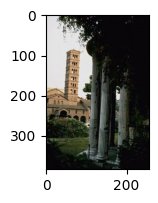

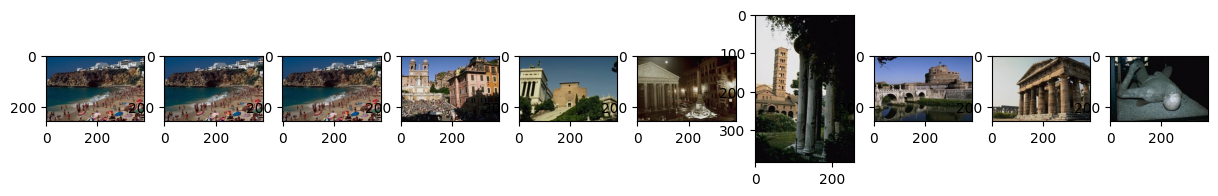

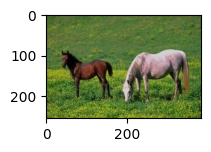

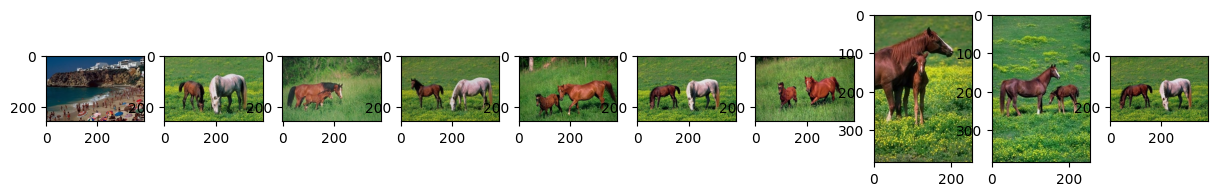

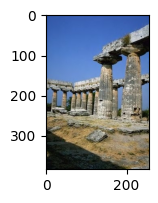

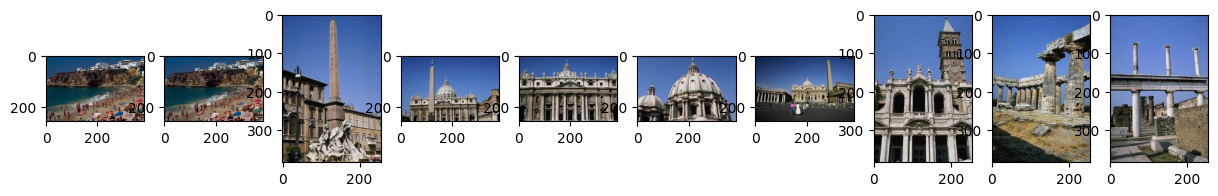

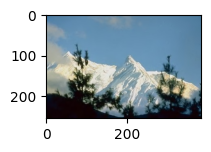

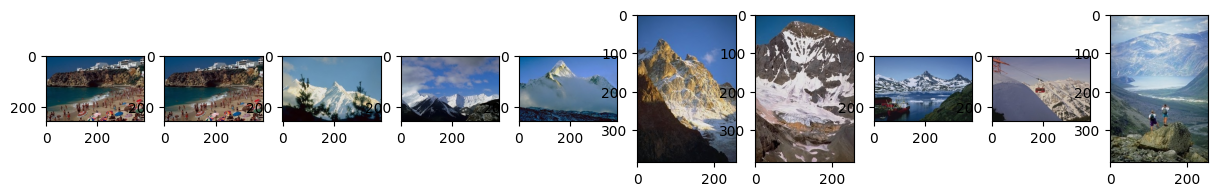

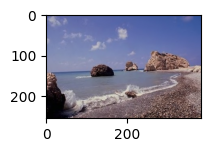

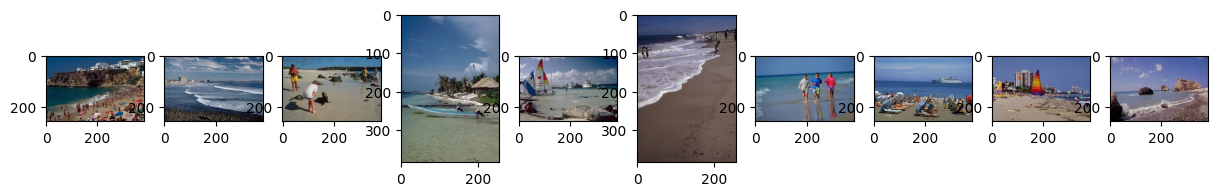

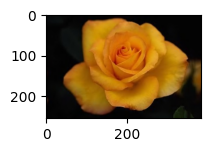

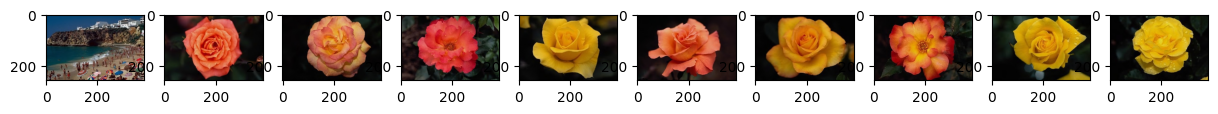

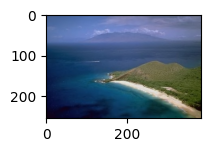

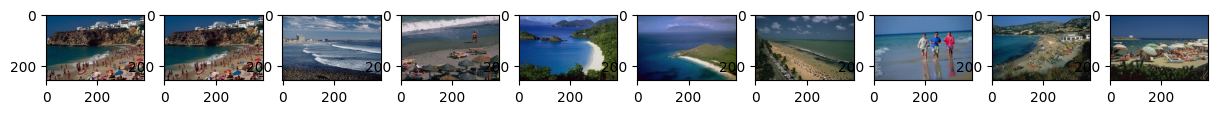

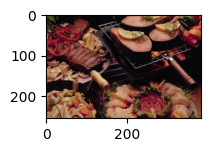

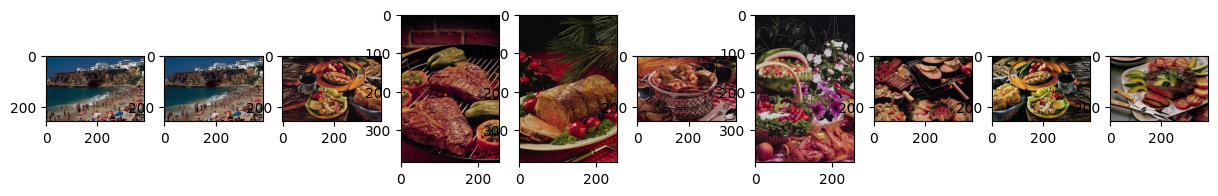

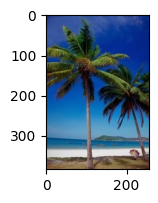

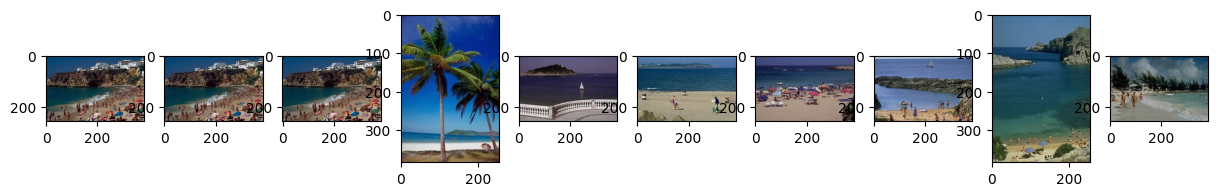

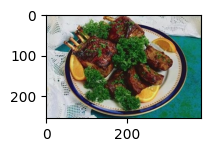

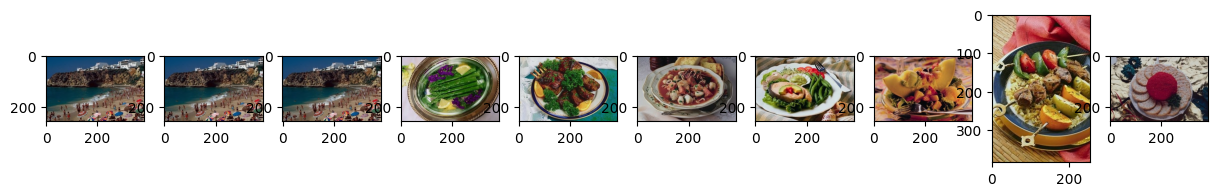

In [ ]:
''' for reverse image retrieval'''

for k in range(len(test)):
    top_k = 10

    result = image_search(images[test[k]],1)
    index = fine_search(images[test[k]],result,top_k)

    # displaying the query image
    plt.figure(figsize=(2,2))
    img = mpimg.imread(filenames[test[k]])
    plt.imshow(img)
    plt.show()

    # displaying the results obtained
    plt.figure(figsize=(15,15))
    for i in range(len(index)):
        plt.subplot(1,10,i+1)
        img = mpimg.imread(filenames[index[i]])
        plt.imshow(img)
    plt.show()